In [1]:
import  pandas as pd

In [2]:
df = pd.read_csv('aadhaar_master_dataset.csv')

In [3]:
df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_',
       'demo_age_5_17', 'demo_age_17_', 'age_0_5', 'age_5_17',
       'age_18_greater', 'total_bio_updates', 'total_demo_updates',
       'total_updates', 'total_enrolments', 'total_transactions'],
      dtype='object')

In [4]:
# Lifecycle 0–5 (enrolment only)
df["lc_0_5"] = df["age_0_5"]

# Lifecycle 5–17
df["lc_5_17"] = (
    df["age_5_17"] +
    df["bio_age_5_17"] +
    df["demo_age_5_17"]
)

# Lifecycle 18+
df["lc_18_plus"] = (
    df["age_18_greater"] +
    df["bio_age_17_"] +
    df["demo_age_17_"]
)



In [5]:
df["total_lifecycle_txns"] = (
    df["lc_0_5"] + df["lc_5_17"] + df["lc_18_plus"]
)

# Avoid division errors
df = df[df["total_lifecycle_txns"] > 0]

df["p_0_5"] = df["lc_0_5"] / df["total_lifecycle_txns"]
df["p_5_17"] = df["lc_5_17"] / df["total_lifecycle_txns"]
df["p_18_plus"] = df["lc_18_plus"] / df["total_lifecycle_txns"]


In [6]:
IDEAL = 1/3

df["lifecycle_deviation"] = (
    abs(df["p_0_5"] - IDEAL) +
    abs(df["p_5_17"] - IDEAL) +
    abs(df["p_18_plus"] - IDEAL)
)


In [7]:
MAX_DEVIATION = 4 / 3

df["ALCS"] = 1 - (df["lifecycle_deviation"] / MAX_DEVIATION)
df["ALCS"] = df["ALCS"].clip(0, 1)


In [8]:
def alcs_category(score):
    if score >= 0.80:
        return "Balanced Coverage"
    elif score >= 0.60:
        return "Mild Lifecycle Skew"
    elif score >= 0.40:
        return "Moderate Lifecycle Gap"
    else:
        return "Severe Lifecycle Exclusion"

df["ALCS_Category"] = df["ALCS"].apply(alcs_category)


In [9]:
df["dominant_lifecycle"] = df[
    ["lc_0_5", "lc_5_17", "lc_18_plus"]
].idxmax(axis=1)


In [10]:
final_cols = [
    "date", "state", "district", "pincode",
    "lc_0_5", "lc_5_17", "lc_18_plus",
    "p_0_5", "p_5_17", "p_18_plus",
    "ALCS", "ALCS_Category", "dominant_lifecycle"
]

alcs_df = df[final_cols]


In [12]:
top_3_districts = (
    df.groupby("district")["ALCS"]
    .mean()
    .sort_values(ascending=False)
    .head(3)
    .index
    .tolist()
)

print("Top 3 Districts by ALCS:", top_3_districts)

Top 3 Districts by ALCS: ['Bengaluru Urban', 'Spsr Nellore', 'Kishtwar']


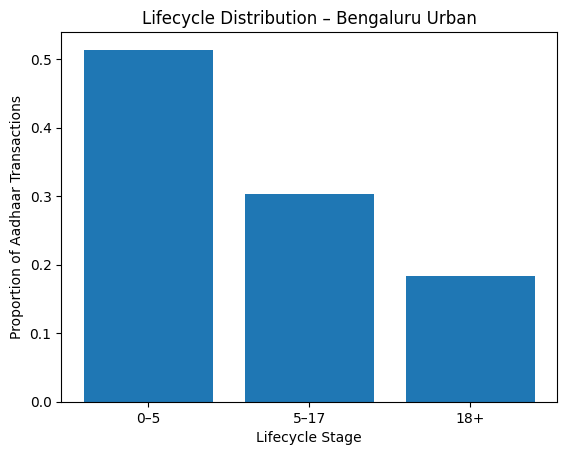

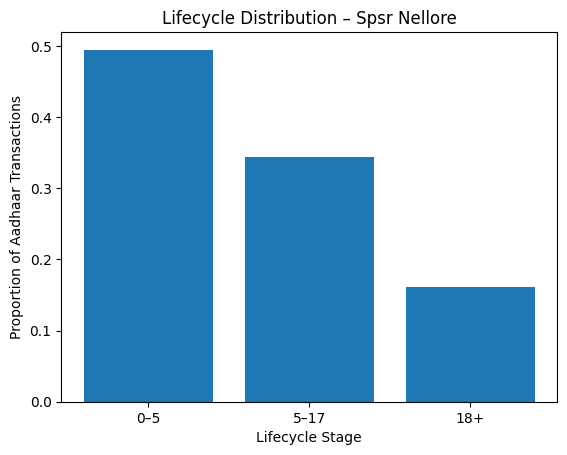

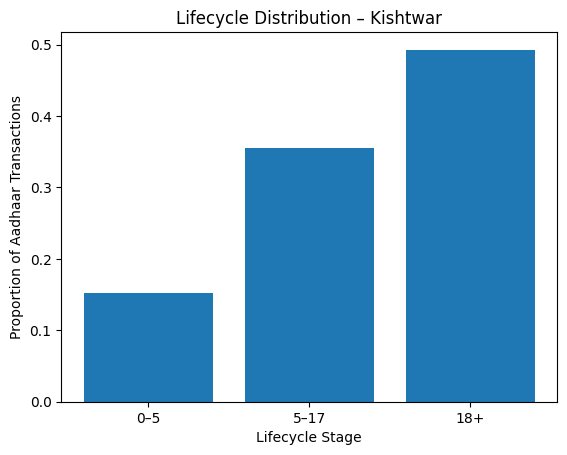

In [13]:
import matplotlib.pyplot as plt

for district in top_3_districts:
    temp = df[df["district"] == district]

    values = [
        temp["p_0_5"].mean(),
        temp["p_5_17"].mean(),
        temp["p_18_plus"].mean()
    ]

    plt.figure()
    plt.bar(["0–5", "5–17", "18+"], values)
    plt.title(f"Lifecycle Distribution – {district}")
    plt.ylabel("Proportion of Aadhaar Transactions")
    plt.xlabel("Lifecycle Stage")
    plt.show()


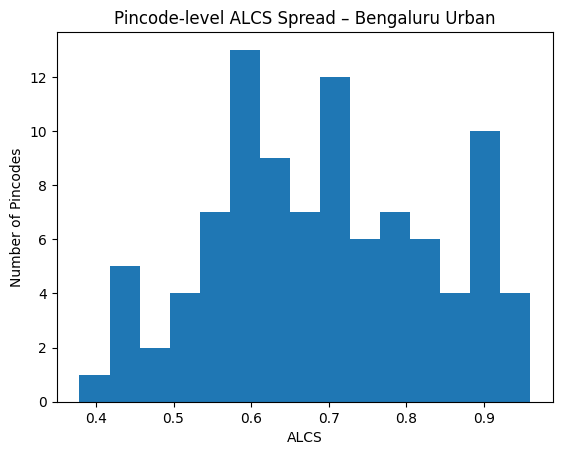

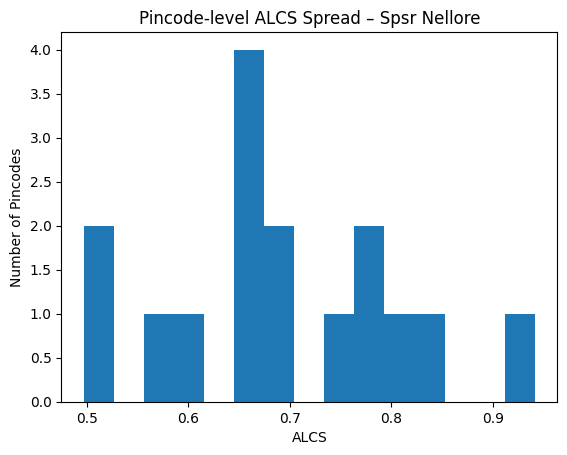

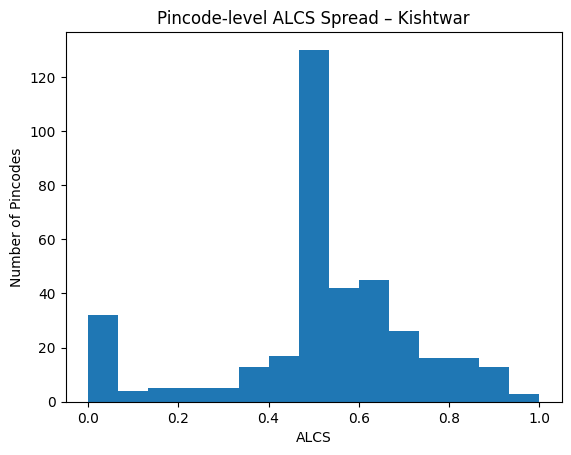

In [14]:
for district in top_3_districts:
    pin_df = df[df["district"] == district]

    plt.figure()
    plt.hist(pin_df["ALCS"], bins=15)
    plt.title(f"Pincode-level ALCS Spread – {district}")
    plt.xlabel("ALCS")
    plt.ylabel("Number of Pincodes")
    plt.show()


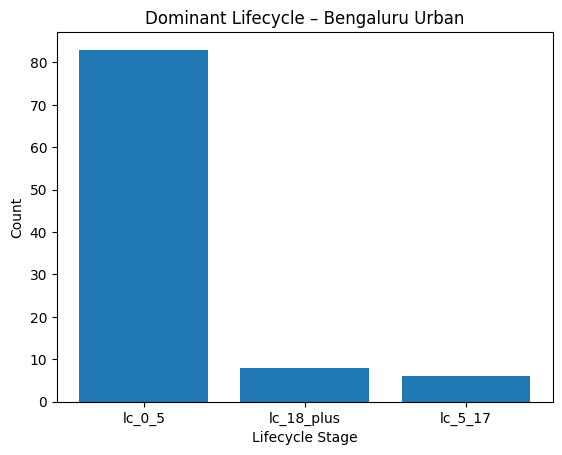

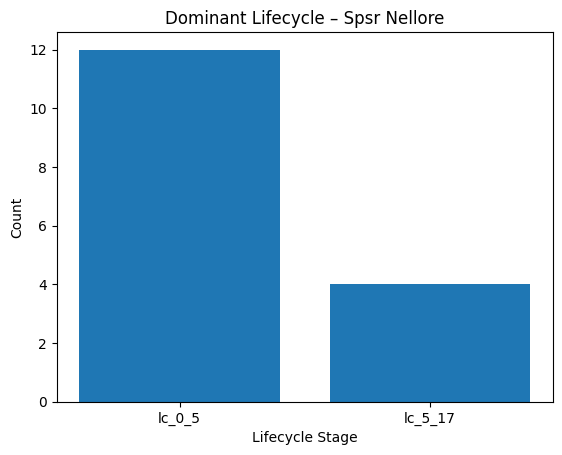

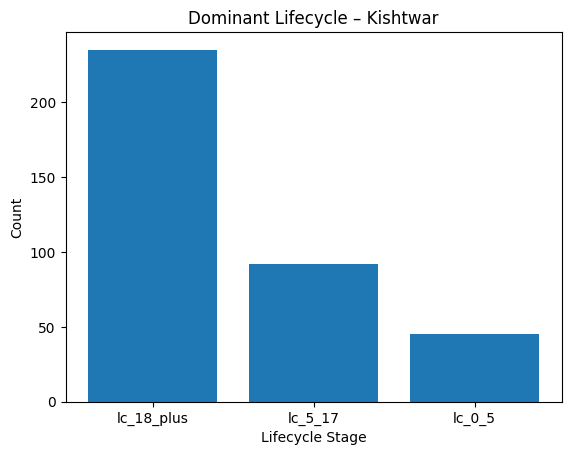

In [15]:
for district in top_3_districts:
    temp = df[df["district"] == district]
    dominance_counts = temp["dominant_lifecycle"].value_counts()

    plt.figure()
    plt.bar(dominance_counts.index, dominance_counts.values)
    plt.title(f"Dominant Lifecycle – {district}")
    plt.xlabel("Lifecycle Stage")
    plt.ylabel("Count")
    plt.show()


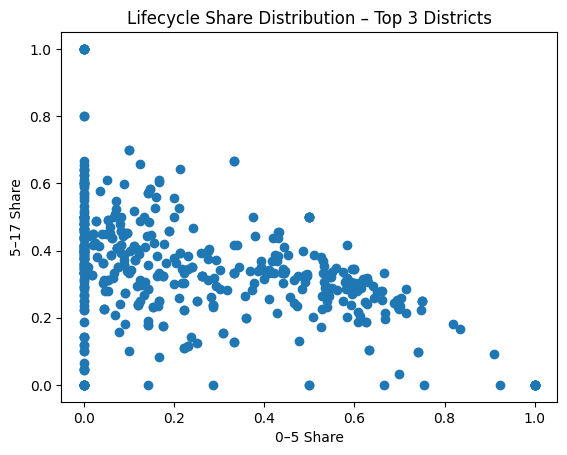

In [16]:
top_df = df[df["district"].isin(top_3_districts)]

plt.figure()
plt.scatter(top_df["p_0_5"], top_df["p_5_17"])
plt.xlabel("0–5 Share")
plt.ylabel("5–17 Share")
plt.title("Lifecycle Share Distribution – Top 3 Districts")
plt.show()


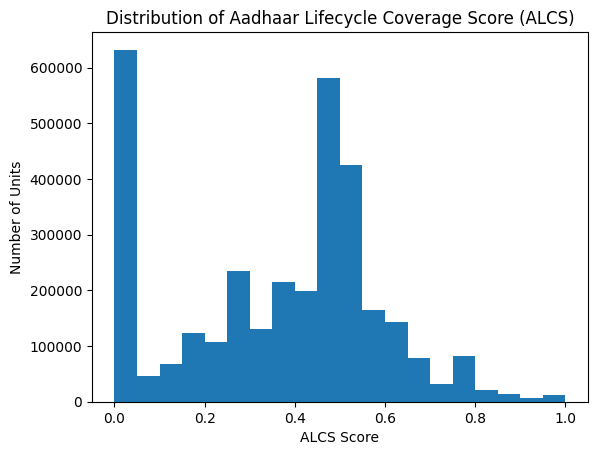

In [17]:
plt.figure()
plt.hist(df["ALCS"], bins=20)
plt.title("Distribution of Aadhaar Lifecycle Coverage Score (ALCS)")
plt.xlabel("ALCS Score")
plt.ylabel("Number of Units")
plt.show()


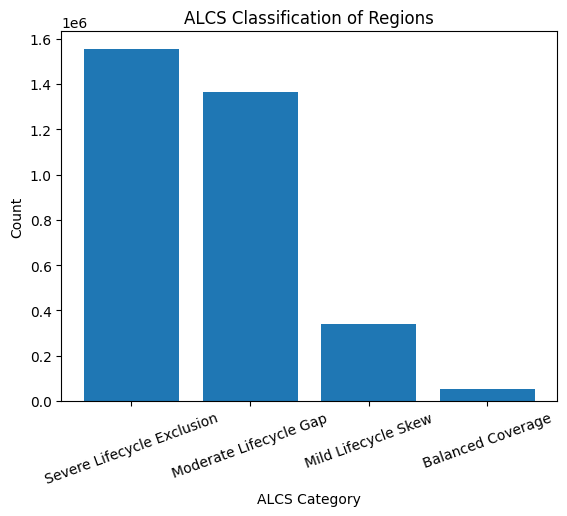

In [18]:
category_counts = df["ALCS_Category"].value_counts()

plt.figure()
plt.bar(category_counts.index, category_counts.values)
plt.title("ALCS Classification of Regions")
plt.ylabel("Count")
plt.xlabel("ALCS Category")
plt.xticks(rotation=20)
plt.show()


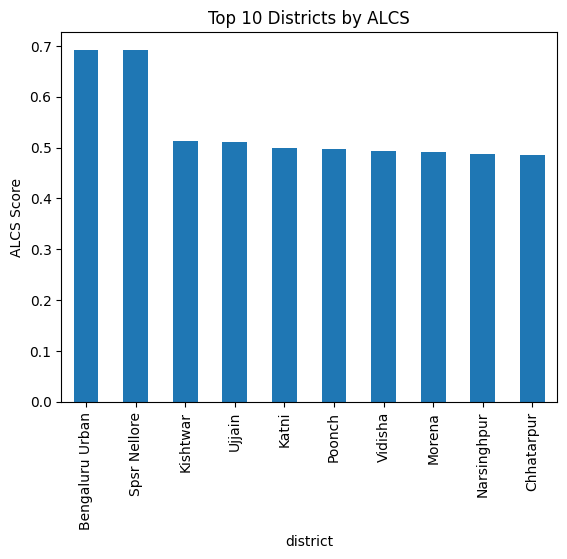

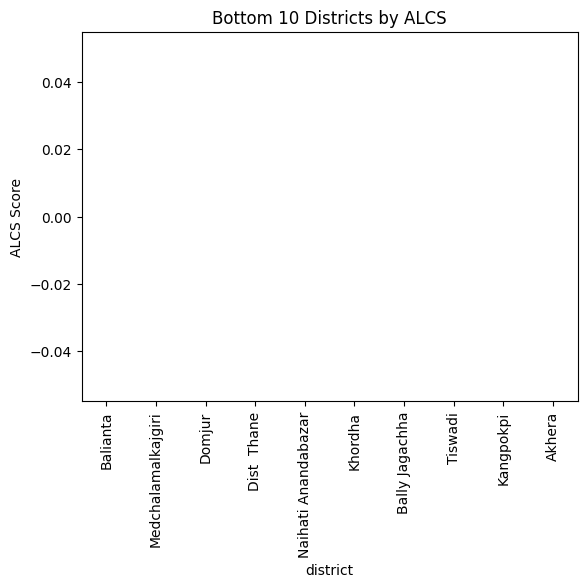

In [19]:
district_alcs = (
    df.groupby("district")["ALCS"]
    .mean()
    .sort_values(ascending=False)
)

# Top 10
plt.figure()
district_alcs.head(10).plot(kind="bar")
plt.title("Top 10 Districts by ALCS")
plt.ylabel("ALCS Score")
plt.show()

# Bottom 10
plt.figure()
district_alcs.tail(10).plot(kind="bar")
plt.title("Bottom 10 Districts by ALCS")
plt.ylabel("ALCS Score")
plt.show()


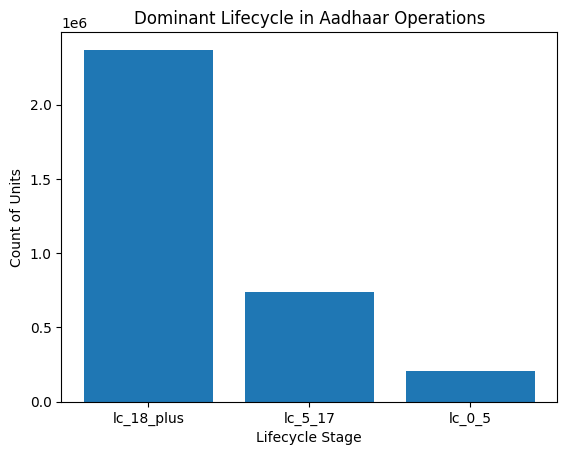

In [20]:
dominance_counts = df["dominant_lifecycle"].value_counts()

plt.figure()
plt.bar(dominance_counts.index, dominance_counts.values)
plt.title("Dominant Lifecycle in Aadhaar Operations")
plt.ylabel("Count of Units")
plt.xlabel("Lifecycle Stage")
plt.show()


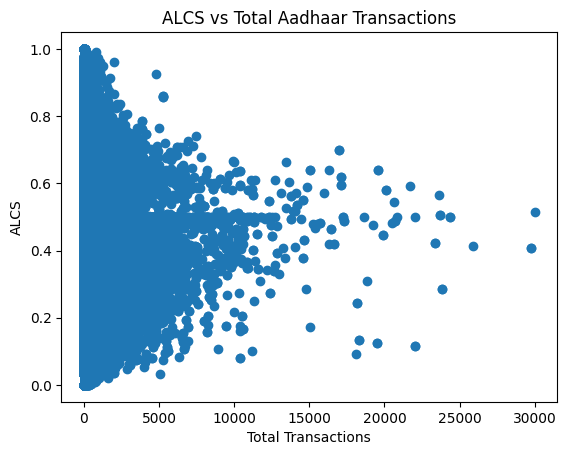

In [21]:
plt.figure()
plt.scatter(df["total_transactions"], df["ALCS"])
plt.title("ALCS vs Total Aadhaar Transactions")
plt.xlabel("Total Transactions")
plt.ylabel("ALCS")
plt.show()


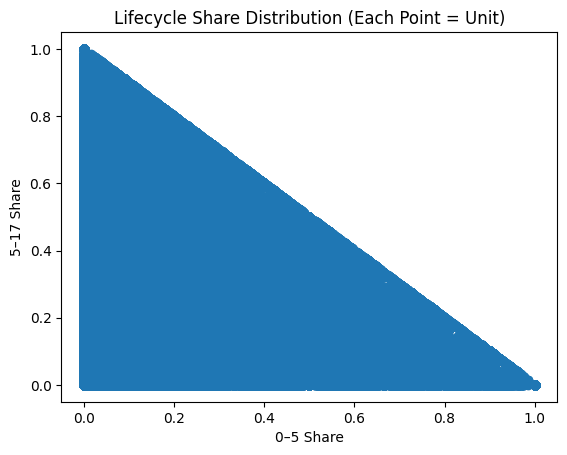

In [22]:
plt.figure()
plt.scatter(df["p_0_5"], df["p_5_17"])
plt.xlabel("0–5 Share")
plt.ylabel("5–17 Share")
plt.title("Lifecycle Share Distribution (Each Point = Unit)")
plt.show()


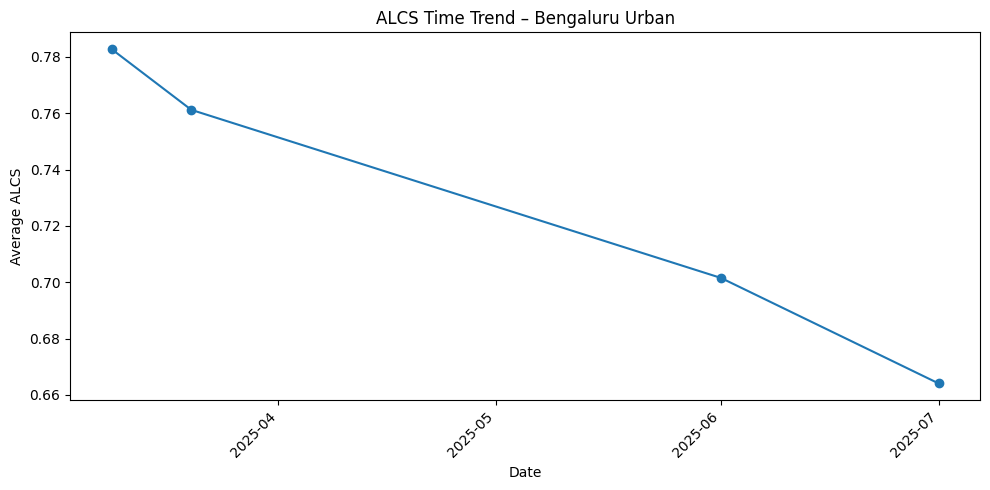

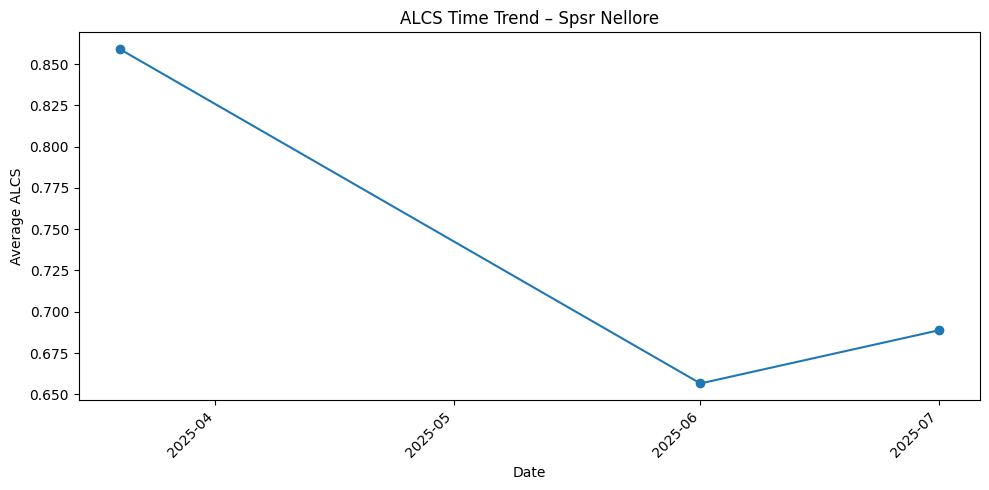

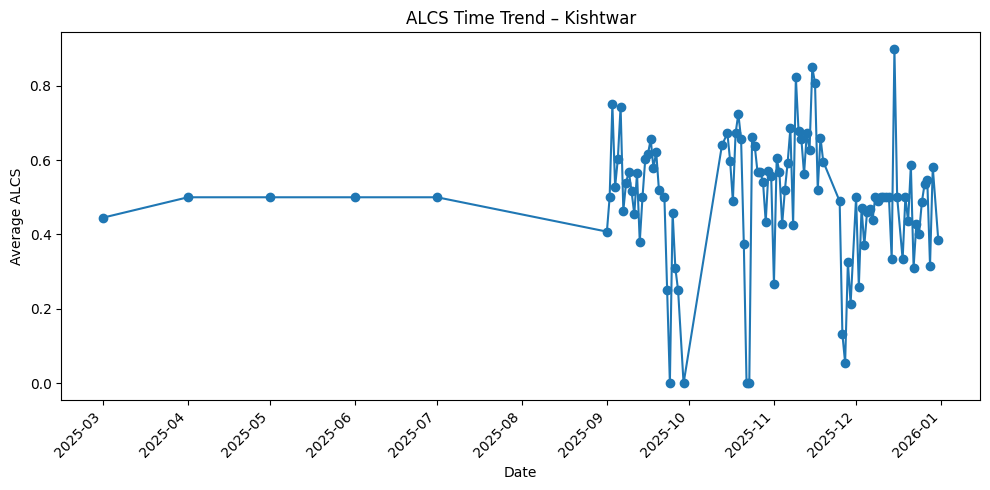

In [23]:
import matplotlib.dates as mdates
import pandas as pd

for district in top_3_districts:
    # Filter and group data
    trend = (
        df[df["district"] == district]
        .copy()
    )
    # Ensure date is datetime
    trend["date"] = pd.to_datetime(trend["date"])
    trend = (
        trend.groupby("date")["ALCS"]
        .mean()
        .sort_index()
    )

    plt.figure(figsize=(10, 5))
    plt.plot(trend.index, trend.values, marker='o')
    plt.title(f"ALCS Time Trend – {district}")
    plt.xlabel("Date")
    plt.ylabel("Average ALCS")

    # Format x-axis dates
    ax = plt.gca()
    # Set major ticks every month
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    # Format major ticks as 'YYYY-MM'
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # Rotate date labels for clarity
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


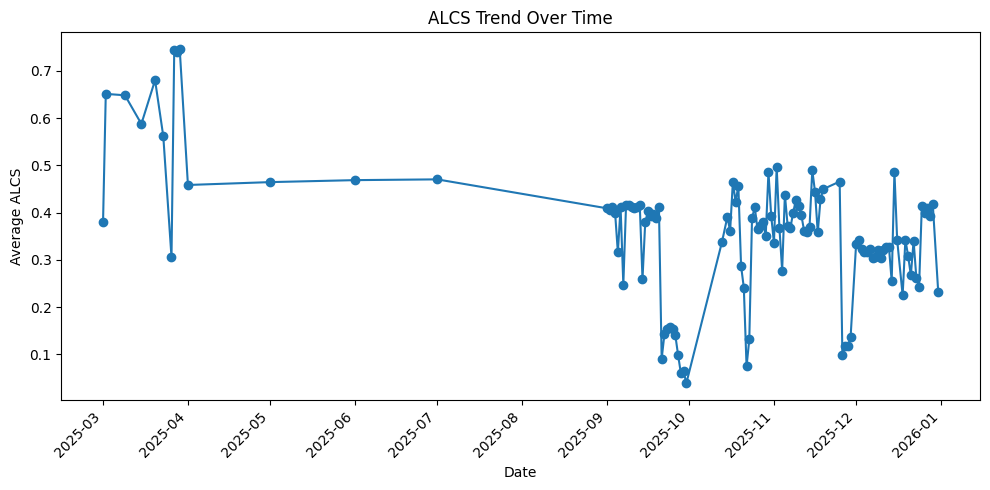

In [24]:

# Ensure date column is datetime type
df["date"] = pd.to_datetime(df["date"])

time_trend = (
    df.groupby("date")["ALCS"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(10, 5))
plt.plot(time_trend.index, time_trend.values, marker='o')
plt.title("ALCS Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Average ALCS")

ax = plt.gca()
# Set major ticks monthly
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Format ticks as Year-Month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Rotate for clarity
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [36]:
import geopandas as gpd

state_alcs = (
    df.groupby("state")["ALCS"]
    .mean()
    .reset_index()
)

india_map = gpd.read_file("State shp\Admin2.shp")


<>:9: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\A'
C:\Users\admin\AppData\Local\Temp\ipykernel_7892\3194936570.py:9: SyntaxWarning: invalid escape sequence '\A'
  india_map = gpd.read_file("State shp\Admin2.shp")


<Figure size 1200x1400 with 0 Axes>

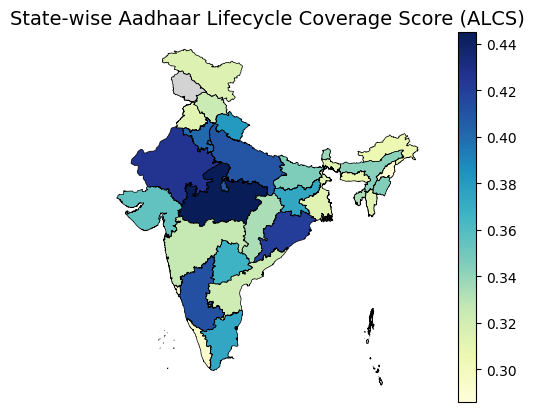

In [37]:
map_df = india_map.merge(
    state_alcs,
    left_on="ST_NM",
    right_on="state",
    how="left"
)


plt.figure(figsize=(12, 14))

map_df.plot(
    column="ALCS",
    cmap="YlGnBu",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No Data"
    }
)

plt.title("State-wise Aadhaar Lifecycle Coverage Score (ALCS)", fontsize=14)
plt.axis("off")
plt.show()



In [38]:
district_map = gpd.read_file("District Shp/2011_Dist.shp")

In [39]:
district_map.columns

Index(['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode',
       'geometry'],
      dtype='object')

<Figure size 1200x1400 with 0 Axes>

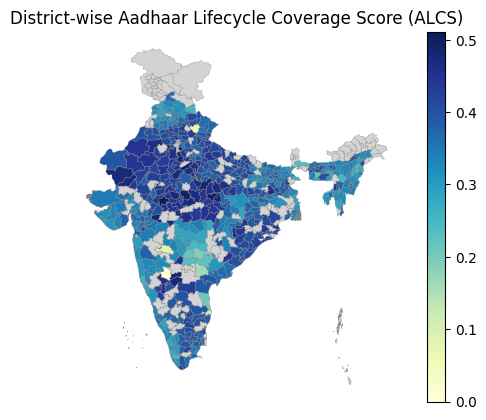

In [42]:
d_alcs = (
    df.groupby(["state", "district"])["ALCS"]
    .mean()
    .reset_index()
)

map_df = district_map.merge(
    d_alcs,
    left_on=["ST_NM", "DISTRICT"],
    right_on=["state", "district"],
    how="left"
)

plt.figure(figsize=(12, 14))
map_df.plot(
    column="ALCS",
    cmap="YlGnBu",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No Data"
    }
)

plt.title("District-wise Aadhaar Lifecycle Coverage Score (ALCS)")
plt.axis("off")
plt.show()



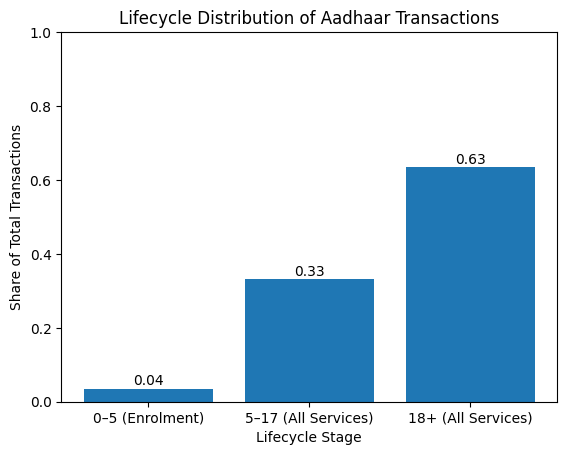

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate lifecycle transactions (overall or after filtering)
lifecycle_totals = {
    "0–5 (Enrolment)": df["age_0_5"].sum(),
    "5–17 (All Services)": (
        df["age_5_17"].sum()
        + df["bio_age_5_17"].sum()
        + df["demo_age_5_17"].sum()
    ),
    "18+ (All Services)": (
        df["age_18_greater"].sum()
        + df["bio_age_17_"].sum()
        + df["demo_age_17_"].sum()
    ),
}

lifecycle_df = pd.DataFrame.from_dict(
    lifecycle_totals, orient="index", columns=["transactions"]
)

# Convert to proportions
lifecycle_df["share"] = lifecycle_df["transactions"] / lifecycle_df["transactions"].sum()

plt.figure()
plt.bar(
    lifecycle_df.index,
    lifecycle_df["share"]
)

plt.title("Lifecycle Distribution of Aadhaar Transactions")
plt.xlabel("Lifecycle Stage")
plt.ylabel("Share of Total Transactions")
plt.ylim(0, 1)

for i, v in enumerate(lifecycle_df["share"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")

plt.show()